# Legalis Extractor

### Notebook used to extract features and create binary values to predict

## importing packages and dataset

#### install libaries with pip (needed especially for only jupyter notebook services, i.e. google collab)

In [3]:
!pip install datasets
!pip install openai
!pip install huggingface-hub

#### imports and huggingface login

In [4]:
#standart imports
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

import datasets as ds #for dataset management and processing
import huggingface_hub #for huggingface login

import openai #openai libary for chatgpt api

huggingface_hub.notebook_login()

#### import of split but not enhanced dataset from huggingface hub or csv, commented out bc not used in production

In [ ]:
#loading dataset from csv (reproduction way)
#dataset=ds.load_dataset("csv", data_files="three-split-dataset.csv")

#loading dataset from huggingface hub (production way)
dataset=ds.load_dataset("LennardZuendorf/openlegaldata-processed", split="three")
print(dataset)

#### import of already enhanced dataset for updates (testing/edit way)

In [10]:
#importing both splits of dataset and merging them back together
#train=ds.load_dataset("LennardZuendorf/legalis", split="train")
#test=ds.load_dataset("LennardZuendorf/legalis", split="test")
#dataset = ds.concatenate_datasets([train,test])

#removing columns for eventual retry (not needed now)
#dataset = dataset.remove_columns(['label', 'winner'])

#print(dataset)

Found cached dataset parquet (C:/Users/lenna/.cache/huggingface/datasets/LennardZuendorf___parquet/LennardZuendorf--legalis-a2e01f8f34ef8796/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (C:/Users/lenna/.cache/huggingface/datasets/LennardZuendorf___parquet/LennardZuendorf--legalis-a2e01f8f34ef8796/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['id', 'file_number', 'date', 'type', 'content', 'tenor', 'facts', 'reasoning', 'winner', 'label'],
    num_rows: 2801
})


## Enhancing Dataset using OpenAI ChatGPT API by extracting winner and prediction label
#### using ChatGPT API to extract a winner from the tenor (summary), including a number label (0/1)

In [9]:
#grabing openai key from environment variable
openai.api_key = os.getenv("openai_token")

#function to extract a label
def winner_extract(data):
  try:
    #creation of chatgpt completion call
    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "You are a legal scholar."},
        {"role": "user", "content":
                            "Extrahiere aus dem folgenden Tenor einer Gerichtsentscheidung den Gewinner der Entscheidung:"
                            +str(data['tenor'])+"Gib den Gewinner so aus: Gewinner: mit 1 für Kläger und 0 für Verklagter."
        }
      ]
    )# error handling
  except openai.error.RateLimitError as e:
    print(f"OpenAI API request exceeded rate limit: {e}")
    time.sleep(5)
    return winner_extract(data)
  except openai.error.ServiceUnavailableError as e:
    print(f"OpenAI API request exceeded rate limit: {e}")
    time.sleep(5)
    return winner_extract(data)
  except Exception as e:
    print(f"encountered unknown error: {e}")
    data['winner'] = "error"
    return data

  #extracting the answer
  data['winner']=completion.choices[0].message['content']
  return data


#batching dataset and running gpt in varibales batches
def batch_runner(data, batch_size, first_batch):
    #first batch
    print("running first batch "+str(0)+" to "+str(first_batch))
    output = ds.Dataset.from_dict(data[:first_batch])
    output = output.map(winner_extract)

    #setting iteration values
    i=first_batch
    e=i+batch_size

    #batch running
    while i<len(data):
        #printing batch progress
        print("running batch "+str(i)+" to "+str(e))

        #creating batch, running function for extraction, appending to output
        tmp_data=ds.Dataset.from_dict(data[i:e])
        tmp_data=tmp_data.map(winner_extract)
        output = ds.concatenate_datasets([output, tmp_data])

        #updating iteration values
        i=e
        e=i+batch_size

    return output

#### creating a binary label from the ChatGPT response and stripping down the text response in winner

In [21]:
def winner_binary(data):
  winner = data['winner']

  #new label if winner is 1 (Klaeger) or 0 (Verklagter), else put other numbers (mostly for statistics)
  if "1" in winner or data['label']==1:
      data['label']=1
      data['winner']="Klaeger*in"
  elif "0" in winner or data['label']==0:
      data['label']=0
      data['winner']="Verklagte*r"
  elif "1" in winner and "0" in winner:
      data['label']=2
  else:
      data['label']=3

  return data

#function to filter out non binary labels
def filter_binary(data):
    if data['label']==2 or data['label']==3:
        return False
    else:
        return True

#### functions to count success and distribution of case outcomes

In [7]:
#counting numbers of success and failure
def count_success(enhanced_dataset):

    #setting variables
    success=0
    fail=0

    #checking success/failure in each case
    for case in dataset:
        if case['label']==1 or case['label']==0:
            success+=1
        elif case['label']==2 or case['label']==3:
            fail+=1

    #combinding values
    dist=[round(success/(success+fail), 2),round(fail/(success+fail),2)]

    #setting dataframe columns and index
    data={'Success': [success, dist[0]], 'Fails': [fail, dist[1]]}
    index=['label nmb.', 'label dist.']

    #return dataframe with statistics
    return pd.DataFrame(data=data, index=index)

#counting distribution of cases
def count_dist(dataset):

    counter_zero=0
    counter_one=0

    #checking outcome for each case
    for case in dataset:
        if case['label']==1:
            counter_one+=1
        elif case['label']==0:
            counter_zero+=1

    #combinding values
    dist=[round(counter_zero/(counter_zero+counter_one),2),round(counter_one/(counter_zero+counter_one),2)]

    #setting dataframe columns and index
    data={'Verklagte*r': [counter_zero, dist[0]], 'Klaeger*in': [counter_one, dist[1]]}
    index=['case nmb.', 'case dist.']

    #return dataframe with statistics
    return pd.DataFrame(data=data, index=index)

#### functions to show metrics in bar charts

In [29]:
#function to show label metrics as numbers of bar chart
def show_label_metrics(label_df):
    #setting values for axis
    labels = label_df.columns
    values = label_df.iloc[0]

    #creating bar chart
    fig, ax = plt.subplots()
    ax.bar(labels, values)
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Cases')
    ax.set_title('Distribution Sucess/Failure Enhancing')

    #displaying dataframe and chart
    display(label_df)
    plt.show()

#function to showcase metrics as numbers of bar chart
def show_case_metrics(case_df):
    #setting values for axis
    cases = case_df.columns
    values = case_df.iloc[0]

    #creating bar chart
    fig, ax = plt.subplots()
    ax.bar(cases, values)
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Cases')
    ax.set_title('Outcome Distribution')

    #displaying dataframe and chart
    display(case_df)
    plt.show()

#### running the enhancing function in batches (won't work without chatgpt api key)

In [23]:
#calling batch runner function to extract labels in batches
enhanced_dataset = batch_runner(dataset, 50, 28)
#setting enhanced dataset to dataset (only needed for fixes for seing metrics)
#enhanced_dataset=dataset

#### creating binary labels, filtering and displaying metrics for both
Comment: For obvious reasons the failure rate will not be accurate as the chatgpt api is not being used here but only the already processed dataset (without filtered out failures)

Success  Fails
label nmb.    2801.0    0.0
label dist.      1.0    0.0

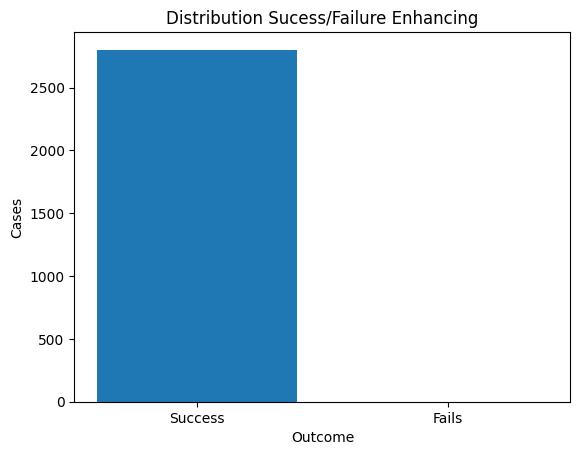

Verklagte*r  Klaeger*in
case nmb.       1705.00     1096.00
case dist.         0.61        0.39

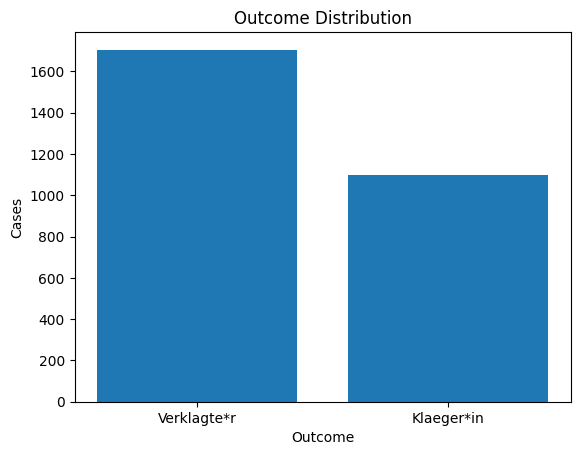

In [30]:
#creating binary labels with chatgpt and displaying metrics
dataset=enhanced_dataset.map(winner_binary)
show_label_metrics(count_success(dataset))

#filtering out non-binary labels and displaying metrics on case outcomes
dataset=dataset.filter(filter_binary)
show_case_metrics(count_dist(dataset))

## Creating Splits, Uploading the new Dataset to HuggingFace Datasets
#### saving dataset as csv file for reproducibility

In [11]:
#saving dataset as csv file for reproducibility (not used in production but can be used to i.e. use other notebooks without huggingface
dataset.to_csv("legalis-dataset.csv")

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

167459878

#### creating traing/test split with datasets function, then pushing the dataset to the huggingface hub

In [8]:
#splitting data
legalis_dataset=dataset.train_test_split(test_size=0.2, shuffle=True)
print(dataset)

#pushing dataset to huggingface hub
legalis_dataset.push_to_hub("LennardZuendorf/legalis", token=os.environ['hub_token'])

AttributeError: 'DatasetDict' object has no attribute 'train_test_split'